# Trabajo práctico 2

In [44]:
import numpy as np
import seaborn as sns
import importlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from data_splitting import split_train_validation
from modelo import LogisticRegressionL2
import metrics
importlib.reload(metrics)

from metrics import save_metrics, confusion_matrix, print_matrix, print_table, plot_combined_pr_curve, plot_combined_roc_curve

In [45]:
def cargar_datos(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)  
    X = data[:, :-1]  
    y = data[:, -1]   
    return X, y


In [46]:
def calcular_pesos_clase(y):
    class_0_weight = np.sum(y == 1) / len(y)
    class_1_weight = np.sum(y == 0) / len(y)
    class_0_weight *= 1.8
    class_1_weight *= 0.5
    return {0: class_0_weight, 1: class_1_weight}


In [47]:
def evaluar_modelo(file_path, modelo):    
    X, y = cargar_datos(file_path)
    X_train, X_val, y_train, y_val = split_train_validation(X, y, 0.2, 42)
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_val)
    y_prob = modelo.predict_proba(X_val)
    metricas = save_metrics(y_val, y_pred, y_prob)

    
    # Calcular la matriz de confusión
    matriz_conf = confusion_matrix(y_val, y_pred)
    return metricas, y_val, y_prob, matriz_conf


In [48]:
def evaluar_modelo_test(file_path_test, modelo):    
    X_test, y_test = cargar_datos(file_path_test)
    
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)
    metricas = save_metrics(y_test, y_pred, y_prob)
    
    # Calcular la matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred)
    return metricas, y_test, y_prob, matriz_conf


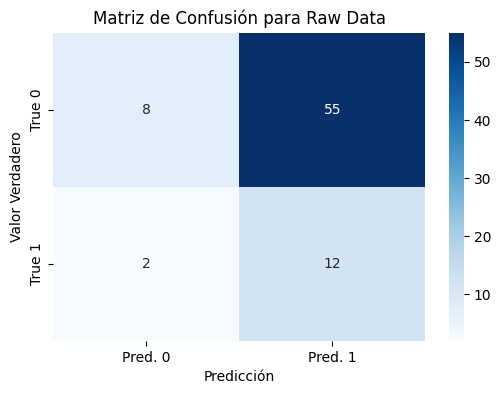

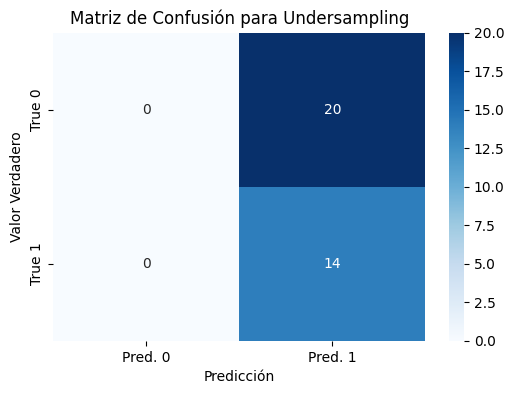

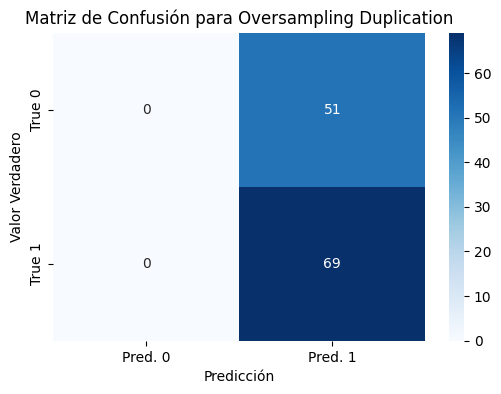

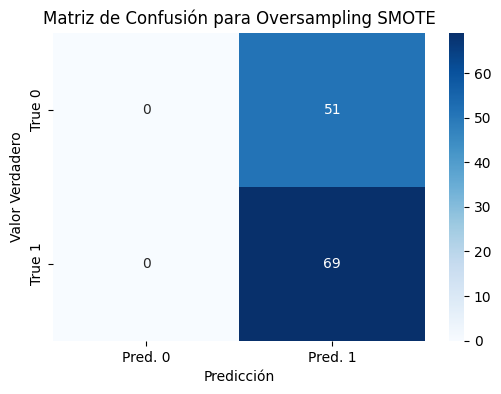

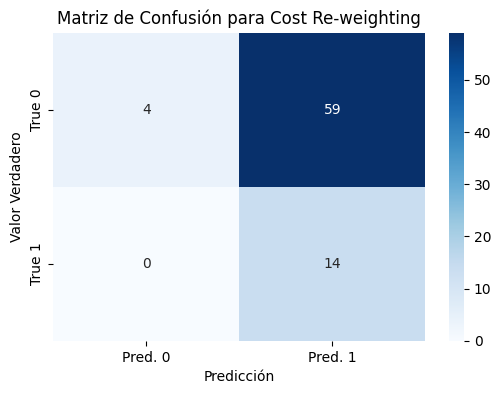


=== Resultados Comparativos Dataset Validation ===
Modelo              Accuracy  Precision Recall    F1-Score  AUC-ROC   AUC-PR    
Raw Data            0.2597    0.1791    0.8571    0.2963    0.4172    0.1575    
Undersampling       0.4118    0.4118    1.0000    0.5833    0.7929    0.6831    
Oversampling Duplication0.5750    0.5750    1.0000    0.7302    0.8738    0.9158    
Oversampling SMOTE  0.5750    0.5750    1.0000    0.7302    0.8645    0.8963    
Cost Re-weighting   0.2338    0.1918    1.0000    0.3218    0.6304    0.2653    


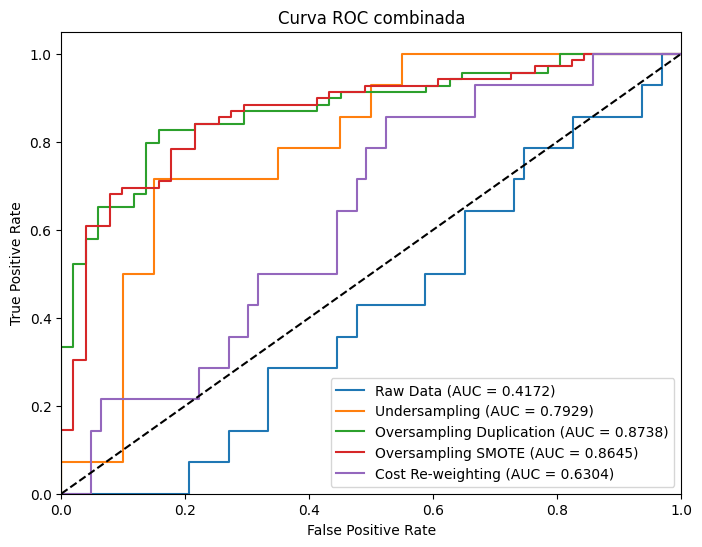

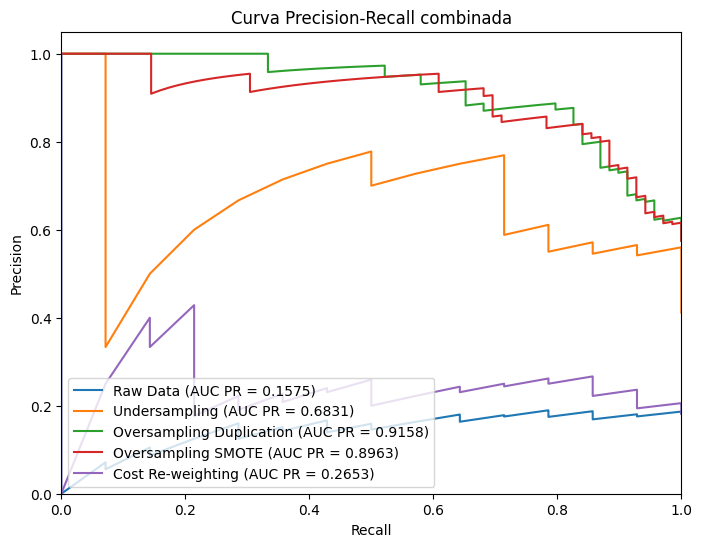

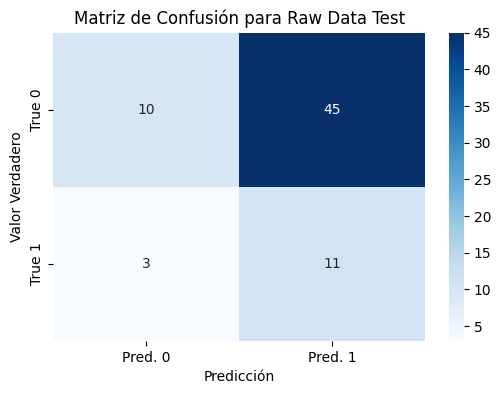

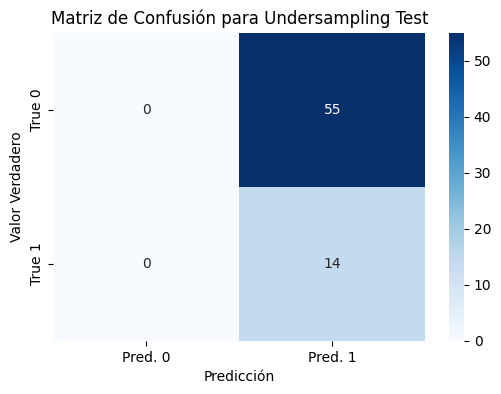

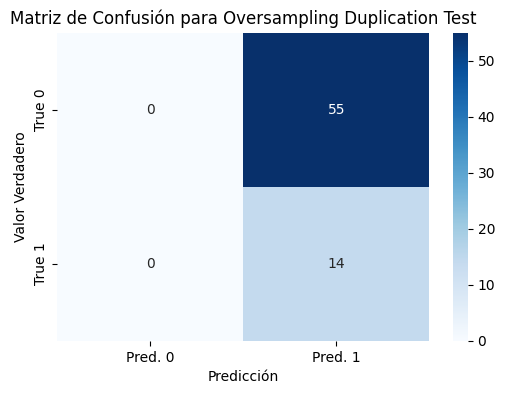

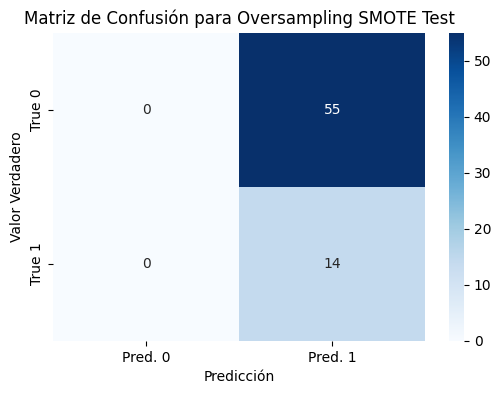

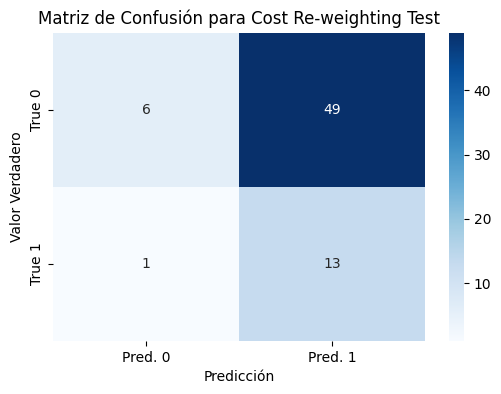


=== Resultados Comparativos Dataset Test ===


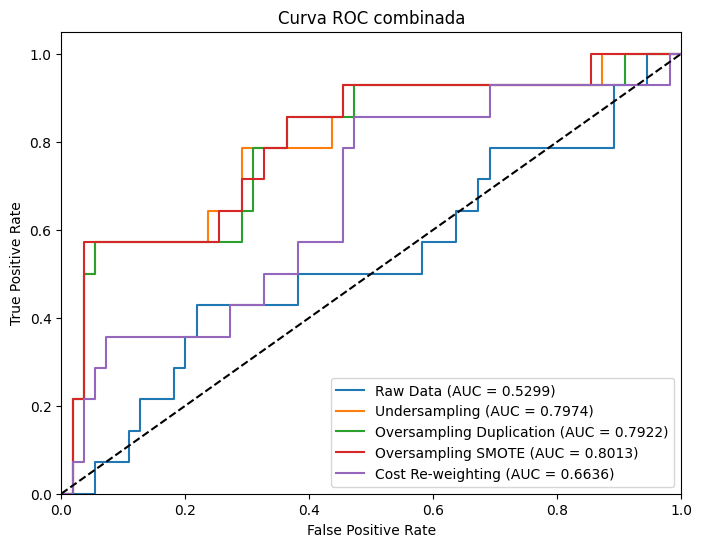

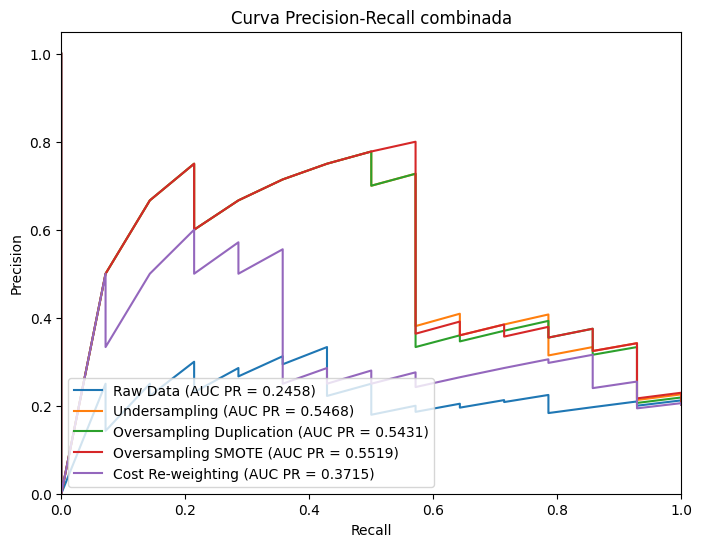

Modelo              Accuracy  Precision Recall    F1-Score  AUC-ROC   AUC-PR    
Raw Data            0.3043    0.1964    0.7857    0.3143    0.5299    0.2458    
Undersampling       0.2029    0.2029    1.0000    0.3373    0.7974    0.5468    
Oversampling Duplication0.2029    0.2029    1.0000    0.3373    0.7922    0.5431    
Oversampling SMOTE  0.2029    0.2029    1.0000    0.3373    0.8013    0.5519    
Cost Re-weighting   0.2754    0.2097    0.9286    0.3421    0.6636    0.3715    


In [59]:
def main():
    datasets = {
        "Raw Data": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/raw/breast_cancer_dev.csv",
        "Undersampling": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/data_undersampling.csv",
        "Oversampling Duplication": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/data_oversampling_duplication.csv",
        "Oversampling SMOTE": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/preprocessed/data_oversampling_smote.csv",
        "Cost Re-weighting": "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/raw/breast_cancer_dev.csv"
    }

    resultados = {}
    y_trues = {}
    y_probs = {}
    y_trues_probs = {}  # Un diccionario que combina y_true y y_prob para cada modelo

    modelos_entrenados = {}

    for nombre, file_path in datasets.items():
        X, y = cargar_datos(file_path)
        
        if nombre == "Cost Re-weighting":
            class_weights = calcular_pesos_clase(y)
            modelo = LogisticRegressionL2(learning_rate=0.1, lambda_=1, num_iters=20000, class_weights=class_weights, threshold=0.40)
        elif nombre == "Raw Data":
            modelo = LogisticRegressionL2(learning_rate=0.01, lambda_=1, num_iters=20000, threshold=0.4)
        else:
            modelo = LogisticRegressionL2(learning_rate=0.00001, lambda_=1, num_iters=10000, threshold=0.4)
    
        metricas, y_val, y_prob, matriz_conf = evaluar_modelo(file_path, modelo)
        resultados[nombre] = metricas
        y_trues[nombre] = y_val
        y_probs[nombre] = y_prob
        y_trues_probs[nombre] = (y_val, y_prob)  

        modelos_entrenados[nombre] = modelo
        print_matrix(matriz_conf, nombre)

    print("\n=== Resultados Comparativos Dataset Validation ===")
    plot_combined_roc_curve(y_trues_probs)
    plot_combined_pr_curve(y_trues_probs)
    print_table(resultados)


# EVALUACIÓN CON DATASET DE TEST
    test_file = "/Users/victoria/Desktop/5tocuatrimestre/ml/tps/tp3ml/machineLearningTP2/problema1/data/raw/breast_cancer_test.csv"
    resultados_test = {}
    y_trues_test = {}
    y_probs_test = {}
    y_trues_test_probs = {} 



    for nombre, modelo in modelos_entrenados.items():
        metricas_test, y_test, y_prob_test, matriz_conf_test = evaluar_modelo_test(test_file, modelo)

        resultados_test[nombre] = metricas_test
        y_trues_test[nombre] = y_test
        y_probs_test[nombre] = y_prob_test
        y_trues_test_probs[nombre] = (y_test, y_prob_test) 
        print_matrix(matriz_conf_test, f"{nombre} Test")


    print("\n=== Resultados Comparativos Dataset Test ===")
    plot_combined_roc_curve(y_trues_test_probs)  
    plot_combined_pr_curve(y_trues_test_probs)  
    print_table(resultados_test)


    return 0

if __name__ == "__main__":
    main()
